In [1]:
import datasets
import debug_helpers
import persistence
import plots
import convergence_criterion as cc
import initializations as inits
import IBM2 as ibm2
import evaluate
import os.path


# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# s_t_pairs, _, _ = datasets.example_data_word_order()

# lprobs_random = inits.initialize_lprobs_randomly(s_t_pairs)
# jump_probs_random = inits.initialize_jump_probs_randomly(s_t_pairs)

# (lprobs, jump_probs, _, _) = ibm2.EM(
#     s_t_pairs, 
#     lprobs_random, 
#     jump_probs_random, 
#     30
# ) 

# s_t_pairs
# debug_helpers.print_lexicon_probs(None, lprobs, None, None)
# jump_probs

# Step 1:
- We run the EM algorithm for 15 iterations.
- During the run we save to disk the models selected by the AER and LL convergence criteria
- After the run we save to disk the AER and LL scores for the iterations
- (for IBM2 we repeat this with different initializations)

In [2]:
def fname_ibm2(fname):
    return f'IBM2_output/{fname}'

# HACK: store converged models during the iteration run
AER_scores = {}
llhood_scores = {}
def save_selected_models(i, llhood, AER, prev_llhood, prev_AER,
                      lprobs, jump_probs, mname):
    debug_helpers.print_likelihood(i, [], llhood, AER)
    if prev_AER and (mname not in AER_scores) and cc.has_converged_AER(prev_AER, AER):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_AER_{i}.txt'))
        AER_scores[mname] = AER
    if prev_llhood and (mname not in llhood_scores) and cc.has_converged_LLhood(prev_llhood, llhood):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_llhood_{i}.txt'))
        llhood_scores[mname] = llhood
        
def run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    fn_init, fn_init_jumps, init_name):

    lprobs_init = fn_init(s_t_pairs)
    jump_probs_init = fn_init_jumps(s_t_pairs)

    # EM
    (lprobs, jump_probs, llhoods, AERs) = ibm2.EM (
        s_t_pairs, 
        lprobs_init, 
        jump_probs_init,
        15,
        val_sentence_pairs, reference_alignments, 
        save_selected_models, init_name)

    # store AER and llhood scores in file
    persistence.save(AERs, fname_ibm2(f'AERs_{init_name}.txt'))
    persistence.save(llhoods, fname_ibm2(f'llhoods_{init_name}.txt'))

    # select models based on AER and llhood selection criterion
    selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
    selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
    print(f'model selected on AER for {init_name}:', selected_model_AER)
    print(f'model selected on LLhood for {init_name}:', selected_model_llhood)

    # plot AER and llhood scores vs iteration
#    plots.figure_log_likelihood(llhoods, fname_ibm2(f'IBM2_{init_name}'))
#    plots.figure_AER(AERs, fname_ibm2(f'IBM2_{init_name}'))

In [5]:
(training_pairs, validation_pairs, test_pairs) = persistence.get_preprocessed_sentence_pairs()
reference_alignments = datasets.validation_alignments()    

# training_pairs, _, _ = datasets.example_data_word_order()
# validation_pairs = None
# reference_alignments = None    

AER_scores = {}
llhood_scores = {}


# Run EM on training data set with AER on validation set
# using uniform initialization 
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_uniform, inits.initialize_jump_probs_uniformly, 'IBM2_uniform')

# Run EM on training data set with AER on validation set
# using initialization with IBM 1 und uniform jump probabilities
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_staged, inits.initialize_jump_probs_uniformly, 'IBM2_staged')

# Run EM on training data set with AER on validation set
# using random initialization (3x)
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_1')
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_2')
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_3')




iteration    log_likelihood    AER    time
0 -35670201.595 0.82908 10:25
1 -22272111.929 0.27951 10:33
2 -17894131.590 0.25118 10:41
3 -16337044.295 0.23418 10:50
4 -15922533.436 0.23324 10:58
5 -15798644.564 0.23135 11:06
6 -15745547.772 0.23041 11:14
7 -15718382.243 0.23135 11:22
8 -15702995.067 0.23229 11:31
9 -15693686.286 0.23607 11:40
10 -15687745.401 0.23607 11:48
11 -15683794.250 0.23607 11:56
12 -15681088.674 0.23985 12:04
13 -15679197.269 0.23985 12:13
14 -15677853.965 0.24174 12:21
model selected on AER for IBM2_uniform: IBM2_output/7
model selected on LLhood for IBM2_uniform: IBM2_output/8
iteration    log_likelihood    AER    time
0 -18799460.302 0.32153 12:33
1 -16781372.212 0.24455 12:42
2 -16239000.772 0.23791 12:50
3 -16024719.771 0.23580 12:58
4 -15913380.977 0.23157 01:07
5 -15845154.026 0.23251 01:15
6 -15800158.109 0.22968 01:24
7 -15769399.904 0.23041 01:33
8 -15747411.258 0.23324 01:41
9 -15730690.830 0.23418 01:49
10 -15718604.486 0.23418 01:58
11 -15709507.030 

KeyboardInterrupt: 

# Step 2:
- We read from disk the AER and LL scores for the different initializations
- We plot those in a multiple line diagram

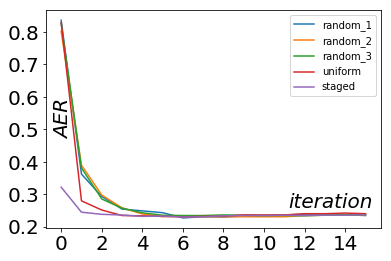

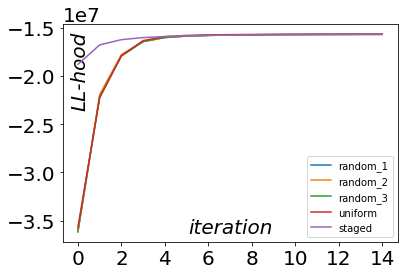

In [10]:
def add_plot_data(init_name, label):
    fname_ibm2_AERs = fname_ibm2(f'AERs_{init_name}.txt')    
    fname_ibm2_llhoods = fname_ibm2(f'llhoods_{init_name}.txt')
    AERs = persistence.load(fname_ibm2_AERs)
    llhoods = persistence.load(fname_ibm2_llhoods)
    AER_lines.append(AERs)
    llhood_lines.append(llhoods)
    model_names.append(label) 
    
AER_lines = []
llhood_lines = []
model_names = []
for i in [1,2, 3]:
    init_name = f'IBM2_RR_{i}'
    add_plot_data(init_name, f'random_{i}')
add_plot_data('IBM2_uniform', 'uniform')
add_plot_data('IBM2_staged', 'staged')

plots.figure_AER_multiple_lines(AER_lines, model_names, fname_ibm2('IBM2_inits_AER.png'))
plots.figure_llhood_multiple_lines(llhood_lines, model_names, fname_ibm2('IBM2_inits_llhoods.png'))

# Step 3:
Plot AER and llhood scores for selected models

In [15]:
AER_scores
llhood_scores
print('For the random models pick the minimal AER score and the maximum llhood score')

{'IBM2_RR_1': 0.23062381852551983,
 'IBM2_RR_2': 0.23229461756373937,
 'IBM2_RR_3': 0.23796033994334276,
 'IBM2_staged': 0.23251417769376181,
 'IBM2_uniform': 0.23135033050047216}

{'IBM2_RR_1': -15716601.415835928,
 'IBM2_RR_2': -15717405.185576126,
 'IBM2_RR_3': -15721721.55419598,
 'IBM2_staged': -15718604.485789482,
 'IBM2_uniform': -15702995.067174641}

For the random models pick the minimal AER score and the maximum llhood score


# old file names
Just some helpers to identify the file names that contains the best AER and LL models for random initialization 

In [13]:
def fname_best_random_AER():
    return

def fname_best_random_LL():
    return


{'IBM2_RR_1': 0.23062381852551983,
 'IBM2_RR_2': 0.23229461756373937,
 'IBM2_RR_3': 0.23796033994334276,
 'IBM2_staged': 0.23251417769376181,
 'IBM2_uniform': 0.23135033050047216}

{'IBM2_RR_1': -15716601.415835928,
 'IBM2_RR_2': -15717405.185576126,
 'IBM2_RR_3': -15721721.55419598,
 'IBM2_staged': -15718604.485789482,
 'IBM2_uniform': -15702995.067174641}

In [ ]:
# Helpers for old generated files
def fname_best_random_AER():
    AER_selected_iterations = [7, 10, 8]
    selected_AER_scores = []
    for i in range(1,4):
        fname_ibm2_AERs = fname_ibm2(f'old/ibm2_AERs_IBM2_rr_{i}.txt')
        it_num = AER_selected_iterations[i - 1]
        AER_rr = persistence.load(fname_ibm2_AERs)[it_num]
        selected_AER_scores.append(AER_rr)
    min_AER = min(selected_AER_scores)
    rr_index = selected_AER_scores.index(min_AER) + 1
    it = AER_selected_iterations[rr_index - 1]
    fname = fname_ibm2(f'old/ibm2_IBM2_rr_{rr_index}_AER_{it}.txt')
    return fname

def fname_best_random_LL():
    LL_selected_iterations = [10, 10, 9]
    selected_LL_scores = []
    for i in range(1,4):
        fname_ibm2_LLs = fname_ibm2(f'old/ibm2_llhoods_IBM2_rr_{i}.txt')
        it_num = LL_selected_iterations[i - 1]
        LL_rr = persistence.load(fname_ibm2_LLs)[it_num]
        selected_LL_scores.append(LL_rr)
    max_LL = max(selected_LL_scores)
    rr_index = selected_LL_scores.index(max_LL) + 1
    it = LL_selected_iterations[rr_index - 1]
    fname = fname_ibm2(f'old/ibm2_IBM2_rr_{rr_index}_llhood_{it}.txt')
    return fname

# Step 4
Find the filenames of the selected models

In [51]:
import os
fnames = os.listdir('IBM2_output')
mfiles = {fname for fname in fnames if 'params' in fname}

# Manually remove random models that were not selected
mfiles = mfiles - {
    'params_IBM2_RR_2_AER_6.txt',
    'params_IBM2_RR_3_AER_9.txt',
    'params_IBM2_RR_2_llhood_9.txt',
    'params_IBM2_RR_3_llhood_10.txt',    
}
mfiles

{'params_IBM2_RR_1_AER_7.txt',
 'params_IBM2_RR_1_llhood_9.txt',
 'params_IBM2_staged_AER_5.txt',
 'params_IBM2_staged_llhood_10.txt',
 'params_IBM2_uniform_AER_7.txt',
 'params_IBM2_uniform_llhood_8.txt'}

# Step 3:
Evaluate the model on the test data using the official tool.
The result is 1) AER score in terminal 2) file in NAACL format that must be part of the submission
(for the best model)

In [ ]:
def evaluate_IBM2_model(test_sentence_pairs, path_to_model, model_name):
    (lprobs, jump_probs) = persistence.load_ibm2_model(path_to_model)
    alignments = ibm2.align(lprobs, jump_probs, test_sentence_pairs)
    evaluate.evaluate_alignments_testset(model_name, alignments)    

model_name_AER = 'IBM2_RR_AER'
path_to_AER_model = fname_best_random_AER()
evaluate_IBM2_model(test_pairs, path_to_AER_model, model_name_AER)

model_name_LL = 'IBM2_RR_LL'
path_to_LL_model = fname_best_random_LL()
evaluate_IBM2_model(test_pairs, path_to_LL_model, model_name_LL)

In [59]:
def evaluate_IBM2_model(test_sentence_pairs, path_to_model, model_name):
    (lprobs, jump_probs) = persistence.load_ibm2_model(path_to_model)
    alignments = ibm2.align(lprobs, jump_probs, test_sentence_pairs)
    evaluate.evaluate_alignments_testset(model_name, alignments)    

for mfile in mfiles:
    mname = mfile[7:-4]
    evaluate_IBM2_model(test_pairs, fname_ibm2(mfile), mname)


File generated: IBM2_staged_AER_5.nonullalign.
Look in terminal to check if --IBM2_staged_AER_5.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
File generated: IBM2_RR_1_AER_7.nonullalign.
Look in terminal to check if --IBM2_RR_1_AER_7.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
File generated: IBM2_uniform_llhood_8.nonullalign.
Look in terminal to check if --IBM2_uniform_llhood_8.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
File generated: IBM2_staged_llhood_10.nonullalign.
Look in terminal to check if --IBM2_staged_llhood_10.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
File generated: IBM2_RR_1_llhood_9.nonullalign.
Look in terminal to check if --IBM2_RR_1_llhood_9.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
File generated: IBM2_uniform_AER_7.nonullalign.
Look in terminal to check if --IBM2_uniform_AER_7.nonullalign-- is in NAACL format...
Lo